In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple, Optional, TypedDict
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [7]:
df = pd.read_csv('C:\\Users\\Thobs\\Desktop\\Portfolio\\Projects\\Data-Science-Projects\\ml-zoomcamp-2024\\homeworks\\hw06\\data\\jamb_exam_results.csv', delimiter=',')

In [10]:
df.tail()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
4995,183,20,74,2,10.6,Public,Urban,Yes,No,Low,Low,4996,16,Male,Medium,Primary,2
4996,179,0,80,2,20.0,Public,Rural,No,Yes,Medium,Medium,4997,22,Male,Low,Secondary,1
4997,261,17,89,3,11.3,Public,Urban,No,No,Low,High,4998,18,Male,Medium,Primary,3
4998,183,15,96,2,15.9,Public,Rural,No,No,Low,Medium,4999,18,Male,Medium,Secondary,1
4999,218,34,100,1,7.0,Public,Urban,Yes,Yes,Medium,Medium,5000,16,Female,High,NaN,2


In [11]:
df.isna().sum()

JAMB_Score                        0
Study_Hours_Per_Week              0
Attendance_Rate                   0
Teacher_Quality                   0
Distance_To_School                0
School_Type                       0
School_Location                   0
Extra_Tutorials                   0
Access_To_Learning_Materials      0
Parent_Involvement                0
IT_Knowledge                      0
Student_ID                        0
Age                               0
Gender                            0
Socioeconomic_Status              0
Parent_Education_Level          891
Assignments_Completed             0
dtype: int64

In [31]:
def prepare_dataset()-> Tuple[scipy.sparse._csr.csr_matrix, scipy.sparse._csr.csr_matrix, pd.DataFrame , pd.Series, pd.Series, pd.Series, DictVectorizer]:
    df = pd.read_csv('C:\\Users\\Thobs\\Desktop\\Portfolio\\Projects\\Data-Science-Projects\\ml-zoomcamp-2024\\homeworks\\hw06\\data\\jamb_exam_results.csv', delimiter=',')
    # Remove the student_id column
    df = df.drop('Student_ID', axis=1)
    # Fill missing values with zeros
    df = df.fillna(0)
    # fill in the 'parent education level' column with the most common value
    df['Parent_Education_Level'] = df['Parent_Education_Level'].fillna(df['Parent_Education_Level'].mode()[0])
    X, y = df.drop('JAMB_Score', axis=1), df['JAMB_Score']
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)
    dv = DictVectorizer(sparse=True)
    X_train_encoded = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val.to_dict(orient='records'))
    return X_train_encoded, X_val_encoded, X_test, y_train, y_val, y_test, dv

    

In [32]:
X_train_encoded, X_val_encoded, X_test, y_train, y_val, y_test, dv = prepare_dataset()

In [46]:

# Question 1

dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train_encoded, y_train)

y_pred = dt.predict(X_val_encoded)
print("mae:",mean_absolute_error(y_val, y_pred.reshape(-1,1)))
print("mape", mean_absolute_percentage_error(y_val, y_pred.reshape(-1,1)))


mae: 36.65618494702799
mape 0.22654154069007476


In [52]:

feature_names = dv.feature_names_
feature_importance = dt.feature_importances_
feature_importance_dict = dict(zip(feature_names, feature_importance))
most_important_feature = max(feature_importance_dict.items(), key=lambda x: x[1])

print(f"The feature used for splitting is: {most_important_feature[0]}")

The feature used for splitting is: Study_Hours_Per_Week


In [53]:
# Question 2

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

y_pred = rf.predict(X_val_encoded)
print("mae:",mean_absolute_error(y_val, y_pred.reshape(-1,1)))
print("mape", mean_absolute_percentage_error(y_val, y_pred.reshape(-1,1)))
print("rmse", np.sqrt(mean_squared_error(y_val, y_pred.reshape(-1,1))))

mae: 33.684
mape 0.20676247693808864
rmse 41.60899752457394


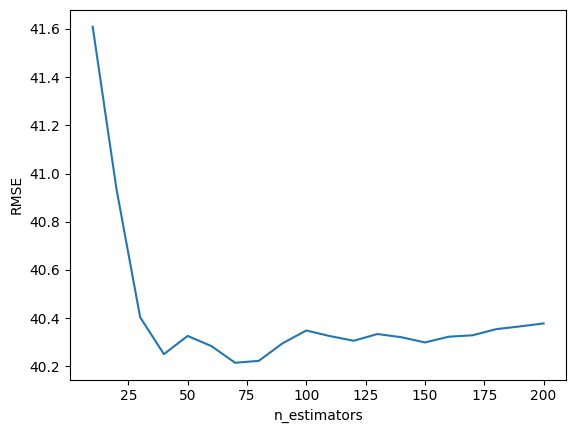

In [54]:
# Question 3

n_estimators_values = range(10, 201, 10)
rmses = []

for n_estimators in n_estimators_values:
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train_encoded, y_train)
    y_pred = rf.predict(X_val_encoded)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred.reshape(-1,1)))
    rmses.append(rmse)

plt.plot(n_estimators_values, rmses)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

In [ ]:
# Question 4

max_depth_values = [10, 15, 20, 25]
n_estimators_values = range(10, 201, 10)
rmses = []
max_depth_dict = {}
for max_depth in max_depth_values:
    for n_estimators in n_estimators_values:
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train_encoded, y_train)
        y_pred = rf.predict(X_val_encoded)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred.reshape(-1,1)))
        rmses.append(rmse)
        max_depth_dict[(max_depth, n_estimators)] = rmse

print(max_depth_dict)
# plt.plot(n_estimators_values, rmses)
# plt.xlabel('n_estimators')
# plt.ylabel('RMSE')
# plt.show()

In [57]:
# rank the max_depth values with minimum RMSE values
# 10 MAX DETPTH, 80 ESTIMATORS


In [62]:
# Question 6

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

dtrain = xgb.DMatrix(X_train_encoded, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val_encoded, label=y_val, feature_names=dv.feature_names_)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = xgb_model.predict(dval)
print("mae:",mean_absolute_error(y_val, y_pred.reshape(-1,1)))
print("mape", mean_absolute_percentage_error(y_val, y_pred.reshape(-1,1)))
print("rmse", np.sqrt(mean_squared_error(y_val, y_pred.reshape(-1,1))))

[0]	train-rmse:42.91051	val-rmse:44.64705
[1]	train-rmse:40.09350	val-rmse:42.60487
[2]	train-rmse:38.20397	val-rmse:41.40159
[3]	train-rmse:36.79464	val-rmse:40.93353
[4]	train-rmse:35.64362	val-rmse:40.56901
[5]	train-rmse:34.71497	val-rmse:40.48899
[6]	train-rmse:34.02343	val-rmse:40.38882
[7]	train-rmse:33.42801	val-rmse:40.30785
[8]	train-rmse:32.83247	val-rmse:40.38901
[9]	train-rmse:32.42530	val-rmse:40.45279
[10]	train-rmse:31.78525	val-rmse:40.54012
[11]	train-rmse:31.16622	val-rmse:40.49581
[12]	train-rmse:30.79841	val-rmse:40.55300
[13]	train-rmse:30.56113	val-rmse:40.51578
[14]	train-rmse:30.15719	val-rmse:40.63918
[15]	train-rmse:29.69317	val-rmse:40.75097
[16]	train-rmse:29.36733	val-rmse:40.79682
[17]	train-rmse:28.92039	val-rmse:40.93162
[18]	train-rmse:28.50678	val-rmse:41.08535
[19]	train-rmse:28.16481	val-rmse:41.07532
[20]	train-rmse:27.74637	val-rmse:41.05446
[21]	train-rmse:27.62998	val-rmse:41.05458
[22]	train-rmse:27.21743	val-rmse:41.30374
[23]	train-rmse:27.02

In [63]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

dtrain = xgb.DMatrix(X_train_encoded, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val_encoded, label=y_val, feature_names=dv.feature_names_)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = xgb_model.predict(dval)
print("mae:",mean_absolute_error(y_val, y_pred.reshape(-1,1)))
print("mape", mean_absolute_percentage_error(y_val, y_pred.reshape(-1,1)))
print("rmse", np.sqrt(mean_squared_error(y_val, y_pred.reshape(-1,1))))

[0]	train-rmse:45.63274	val-rmse:46.87538
[1]	train-rmse:44.30763	val-rmse:45.80280
[2]	train-rmse:43.11201	val-rmse:44.85602
[3]	train-rmse:42.08628	val-rmse:44.11227
[4]	train-rmse:41.14641	val-rmse:43.38290
[5]	train-rmse:40.31147	val-rmse:42.78603
[6]	train-rmse:39.60832	val-rmse:42.23248
[7]	train-rmse:38.94806	val-rmse:41.84044
[8]	train-rmse:38.40949	val-rmse:41.50510
[9]	train-rmse:37.83180	val-rmse:41.16108
[10]	train-rmse:37.33867	val-rmse:40.90394
[11]	train-rmse:36.89943	val-rmse:40.67772
[12]	train-rmse:36.48706	val-rmse:40.50860
[13]	train-rmse:36.11793	val-rmse:40.35888
[14]	train-rmse:35.77876	val-rmse:40.24602
[15]	train-rmse:35.45522	val-rmse:40.12821
[16]	train-rmse:35.09494	val-rmse:40.00583
[17]	train-rmse:34.81707	val-rmse:39.92723
[18]	train-rmse:34.49344	val-rmse:39.84298
[19]	train-rmse:34.21822	val-rmse:39.79007
[20]	train-rmse:33.95054	val-rmse:39.77532
[21]	train-rmse:33.70425	val-rmse:39.71921
[22]	train-rmse:33.49153	val-rmse:39.69830
[23]	train-rmse:33.28